## Importeer bibliotheken

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
import os

## Laad de geveltekening in
De afbeelding wordt geladen met alpha-kanaal als dat beschikbaar is. De afmetingen worden weergegeven

In [6]:
img = cv2.imread("Data_nest_uitgesneden\half_vrijstaand_type_e (1).png")
# img =cv2.imread("Data_nest_uitgesneden\halfvrijestaande (4).png") # Voor het testen

print(f"Afbeelding geladen. Formaat: {img.shape}")

Afbeelding geladen. Formaat: (765, 1194, 3)


<>:1: SyntaxWarning: invalid escape sequence '\h'
<>:1: SyntaxWarning: invalid escape sequence '\h'
C:\Users\Mustafa\AppData\Local\Temp\ipykernel_15568\2120129831.py:1: SyntaxWarning: invalid escape sequence '\h'
  img = cv2.imread("Data_nest_uitgesneden\half_vrijstaand_type_e (1).png")


## Toon de originele geveltekening

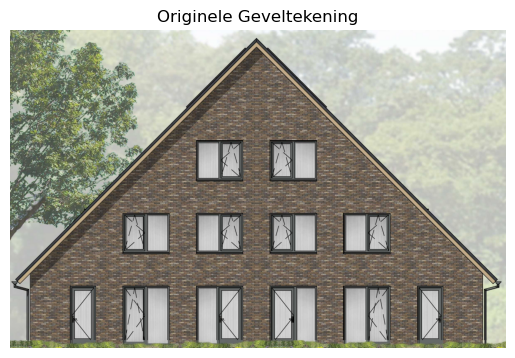

In [7]:
# Zet BGR naar RGB om correct weer te geven met matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

# Toon de originele afbeelding 
plt.imshow(img_rgb)
plt.title("Originele Geveltekening")
plt.axis('off')
plt.show()

## Zet afbeelding om naar grijswaarden

Voor veel beeldverwerkingstaken zoals randdetectie is kleurinformatie niet nodig. 
Door de afbeelding om te zetten naar grijswaarden:

- Verminderen we de hoeveelheid gegevens (van 3 kanalen naar 1).
- Worden randen en vormen duidelijker.
- Gaat de verwerking sneller en efficiënter.

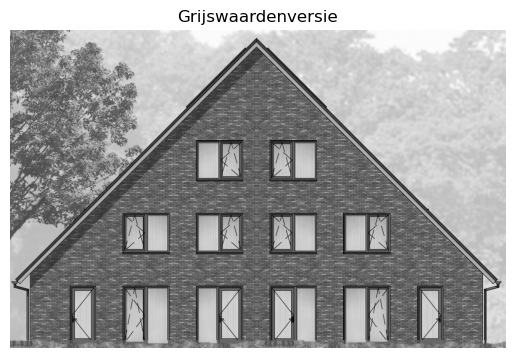

In [8]:
# Converteer afbeelding naar grijswaarden
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Toon de grijswaardenafbeelding
plt.imshow(gray, cmap='gray')
plt.title("Grijswaardenversie")
plt.axis('off')
plt.show()

## Gaussian Blur toepassen om ruis te verminderen

We gebruiken een Gaussian Blur om het beeld te vervagen en kleine ruis of details te onderdrukken. 
Dit zorgt ervoor dat de randdetectie robuuster en minder gevoelig is voor kleine afwijkingen.

De gekozen parameters voor de kernelgrootte `(13, 13)` en standaarddeviatie `2.2` zijn bepaald op basis van visuele inspectie. 
Er is geen automatische methode toegepast; we hebben geëvalueerd wat subjectief het beste resultaat geeft.

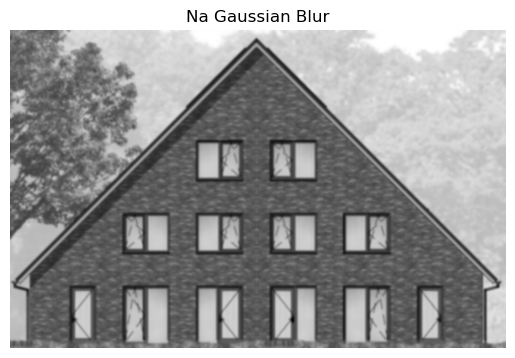

In [9]:
# Pas Gaussian Blur toe op de grijswaardenafbeelding
blur = cv2.GaussianBlur(gray, (13, 13), 2.2)

# Toon de afbeelding na Gaussian Blur
plt.imshow(blur, cmap='gray')
plt.title("Na Gaussian Blur")
plt.axis('off')
plt.show()

## Voer Canny-randdetectie uit

We gebruiken het Canny-algoritme om randen te detecteren in het vervaagde beeld. Canny werkt in meerdere stappen:

- Het berekent de gradiënten (sterke helderheidsveranderingen) in het beeld.
- Alleen overgangen die binnen twee drempelwaarden vallen, worden als randen herkend.
- Dankzij deze aanpak is Canny effectief in het vinden van echte randen en relatief ongevoelig voor ruis — vooral na het toepassen van een Gaussian Blur.

De gebruikte drempelwaarden `(50, 150)` zijn gekozen op basis van visuele inspectie. Er is geen automatische optimalisatie toegepast; we hebben geëvalueerd wat subjectief het meest betrouwbare resultaat geeft voor dit type afbeelding.

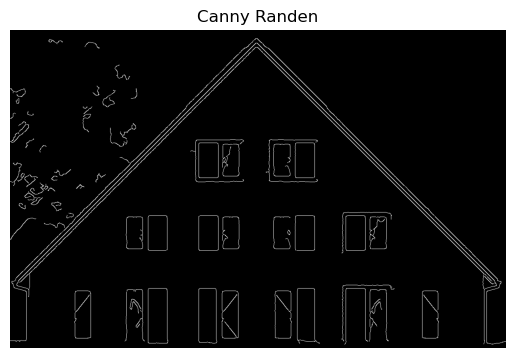

In [10]:
# Pas Canny edge-detectie toe op de vervaagde afbeelding
edges = cv2.Canny(blur, 50, 150)

# Toon de gedetecteerde randen
plt.imshow(edges, cmap='gray')
plt.title("Canny Randen")
plt.axis('off')
plt.show()

## Het resultaat

We zien dat de ramen onderbroken en niet gesloten zijn door de vervaging in de foto. Hierdoor ontstaan er gaten in de randen die het detectieproces verstoren. Om deze gaten te dichten en de randen te versterken, passen we een morfologische sluitingsbewerking toe. Dit helpt om de structuur van de randen te verbeteren en maakt de segmentatie nauwkeuriger.


## Voer morfologische sluiting uit

Deze stap helpt om onderbroken randen te verbinden en kleine gaten te vullen

#### Effect van morfologische sluiting

- **Doel:** Vult gaten en verwijdert inkepingen in randen.
- **Kernel:** `np.ones((30, 30), np.uint8)`  
  Een matrix van 30×30 enen (vierkant structuurelement).
- **Grootte-effect:**  
  - Grote kernels vullen grotere gaten.  
  - Kleine kernels behouden details.


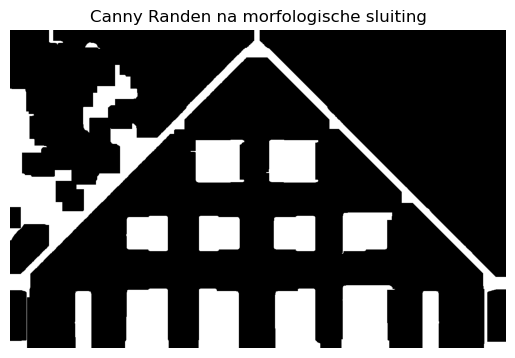

In [11]:
# Morfologische sluiting om gaten te vullen
kernel = np.ones((50, 50), np.uint8) # kernel: Een structurerend element dat bepaalt hoe de operatie wordt toegepast. In dit geval is het een vierkante kernel van 30×30 pixels.

closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel) #MORPH_CLOSE:Dit specificeert het type morfologische operatie dat we willen uitvoeren, in dit geval 'sluiting' (closing).
# # print(closed)
plt.imshow(closed, cmap='gray')
plt.title("Canny Randen na morfologische sluiting")
plt.axis('off')
plt.show()

## Het resultaat

We kunnen visueel zien dat het resultaat is verbeterd: ramen en deuren zijn duidelijk van elkaar te onderscheiden, evenals het hele huis.  
De gevel is beter en scherper zichtbaar geworden. De morfologische sluiting levert een goed resultaat op voor deze gevel.

Nu is het tijd om de daadwerkelijke detectie uit te voeren en het eindresultaat te beoordelen.

## Contourdetectie en objectclassificatie
We vinden de contouren van objecten in de afbeelding (zoals ramen en deuren), bepalen hun grootte en aspect ratio en classificeren ze. Objecten worden met rechthoeken en labels op de afbeelding getekend.

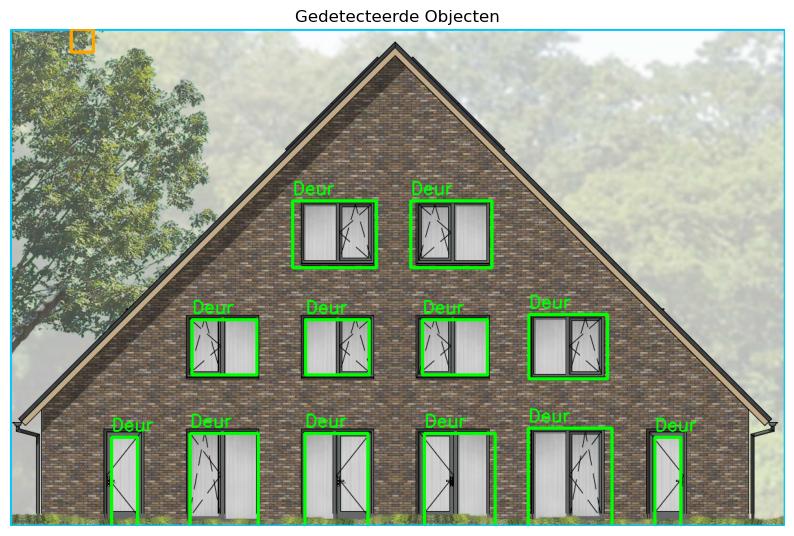

In [12]:
# Vind contouren in het gesloten (closed) beeld
contours, _ = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Maak een kopie van de originele RGB-afbeelding om rechthoeken op te tekenen
output_img = img_rgb.copy()


# Bepaal de grootste contour op basis van oppervlak
largest_cnt = max(contours, key=lambda c: cv2.boundingRect(c)[2] * cv2.boundingRect(c)[3])

largest_area = cv2.boundingRect(largest_cnt)[2] * cv2.boundingRect(largest_cnt)[3]
min_area_deur = 5000
max_area_deur = 20000
min_area_raam = 1000
max_area_raam = 5000

detected_objects = []

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    area = w * h
    aspect_ratio = w / h if h != 0 else 0


    if cnt is largest_cnt:
        label = "Huis"
        color = (0, 200, 255)  # blauw
    elif min_area_deur < area < max_area_deur:
        label = "Deur"
        color = (0, 255, 0)  # groen
    elif min_area_raam < area < max_area_raam:
        label = "Raam"
        color = (255, 165, 0)  # oranje
    else:
        continue  # negeer kleine objecten

    # Teken rechthoek en label
    cv2.rectangle(output_img, (x, y), (x + w, y + h), color, 3)
    cv2.putText(output_img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Toon resultaat
plt.figure(figsize=(10, 10))
plt.imshow(output_img)
plt.title("Gedetecteerde Objecten")
plt.axis('off')
plt.show()

## Conclusie

De detectie van de gevel is correct uitgevoerd en geeft een goed resultaat voor de afbeelding "`half_vrijstaand_type_e (1).png`".  
Er zijn enkele kleine fouten bij het onderscheiden van ramen en deuren; soms wordt een raam als deur beschouwd. Dit is echter acceptabel zolang het model alle objectvormen kan vinden.

Bij het uitvoeren van de detectie op een andere gevel zien we dat het model een slechter resultaat oplevert. Dit is duidelijk te zien aan de hand van de afbeelding "`half_vrijstaand_type_e (2).png`".

De volgende cel legt uit wat er misgaat en waarom dit gebeurt.


## Voorbeeld  
### Effect van morfologische sluiting op vormdetectie

In dit voorbeeld maken we vier eenvoudige vormen om te illustreren hoe morfologische sluiting werkt.  
We doen dit om het effect begrijpelijk te maken, los van de complexiteit van echte gevelafbeeldingen.

We voegen bewust gaten toe in de vormen om te simuleren hoe imperfecties in beelden — zoals ruis, beschadigingen of open randen — invloed hebben op de detectie.


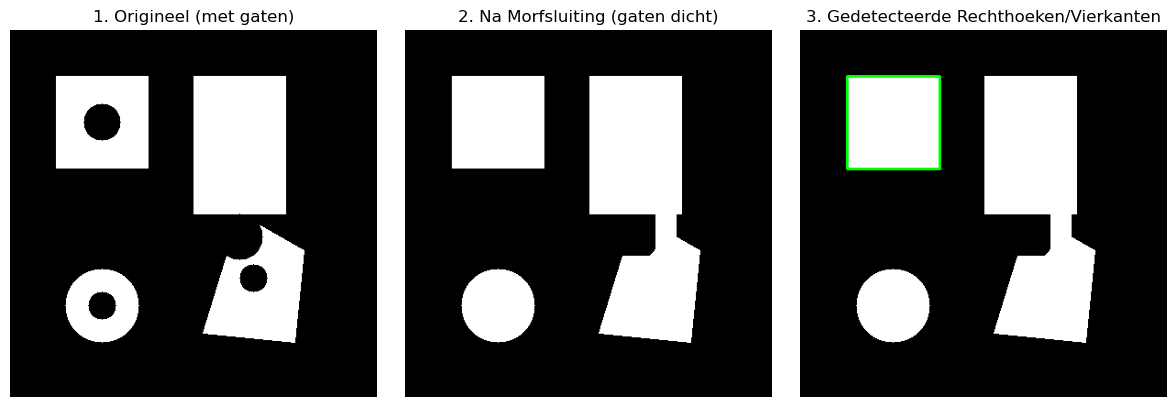

In [13]:
# Stap 1: Maak een testafbeelding met rechthoeken en cirkels
img = np.zeros((400, 400), dtype=np.uint8)

# Teken witte vormen
cv2.rectangle(img, (50, 50), (150, 150), 255, -1)    # Vierkant (want breedte=hoogte)
cv2.rectangle(img, (200, 50), (300, 200), 255, -1)   # Rechthoek
cv2.circle(img, (100, 300), 40, 255, -1)             # Grote cirkel (wit)

# Onregelmatige vierhoek
pts = np.array([[250, 200], [320, 240], [310, 340], [210, 330]], np.int32)
pts = pts.reshape((-1, 1, 2))
cv2.fillPoly(img, [pts], 255)

# Voeg gaten toe in alle vormen (zwarte cirkels)
cv2.circle(img, (100, 100), 20, 0, -1)     # Gat in vierkant
cv2.circle(img, (250, 225), 25, 0, -1)     # Gat in rechthoek
cv2.circle(img, (265, 270), 15, 0, -1)     # Gat in vierhoek
cv2.circle(img, (100, 300), 15, 0, -1)     # Gat in grote cirkel

# Toon de originele afbeelding (zonder tekst)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title("1. Origineel (met gaten)")
plt.axis('off')

# Stap 2: Morfologische sluiting
kernel = np.ones((25, 40), np.uint8)
img_closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

plt.subplot(1, 3, 2)
plt.imshow(img_closed, cmap='gray', vmin=0, vmax=255)
plt.title("2. Na Morfsluiting (gaten dicht)")
plt.axis('off')

# Stap 3: Detecteer en label rechthoeken (zonder tekstlabels)
output_detected = cv2.cvtColor(img_closed, cv2.COLOR_GRAY2BGR)
contours, _ = cv2.findContours(img_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
    x, y, w, h = cv2.boundingRect(cnt)
    
    if len(approx) == 4 and w * h > 1000:
        # Teken alleen de bounding box zonder label
        cv2.rectangle(output_detected, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(output_detected, cv2.COLOR_BGR2RGB))
plt.title("3. Gedetecteerde Rechthoeken/Vierkanten")
plt.axis('off')

plt.tight_layout()
plt.show()

#### Uitleg

In de originele afbeelding zijn vier witte vormen te zien: een vierkant, een rechthoek, een cirkel en een onregelmatige vierhoek.  
In drie vorm is een zwart gat toegevoegd om een realistisch scenario te simuleren waarin er openingen of beschadigingen aanwezig zijn.

Na het toepassen van **morfologische sluiting** worden deze gaten effectief opgevuld.  
Hierdoor lijken de vormen weer volledig gesloten, wat gunstig is bij objectdetectie.

Er ontstaat echter een probleem: sommige vormen liggen dicht bij elkaar.  
Door de relatief grote kernel worden niet alleen de gaten gedicht, maar worden ook **twee afzonderlijke vormen onbedoeld met elkaar verbonden** (zoals de rechthoek en de vierhoek).

Gevolg: het algoritme ziet dit als **één grote onregelmatige vorm**, terwijl het er in werkelijkheid twee zijn.  
Omdat het systeem objecten classificeert op basis van hun **oppervlakte** en **aspect ratio**, wordt de oorspronkelijke logica hierdoor verstoord.  
De structuur van het beeld is veranderd en dus werkt de detectie minder nauwkeurig.


## Gevelobjectdetectie op meerdere afbeeldingen

In deze notebook voeren we een eenvoudige objectdetectie uit op gevelafbeeldingen. De pipeline herkent:
- het grootste object als **"Huis"**,
- objecten van middelgroot formaat als **"Deur"**,
- kleinere rechthoeken als **"Raam"**.

De resultaten worden per afbeelding getoond én automatisch opgeslagen in een lokale folder:
`Nest-Project/Old_school_AI_test_foto's\model_3`.

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Mustafa\AppData\Local\Temp\ipykernel_15568\151130365.py:2: SyntaxWarning: invalid escape sequence '\m'
  save_folder = os.path.join(".", "Old_school_AI_test_foto's\model_2")


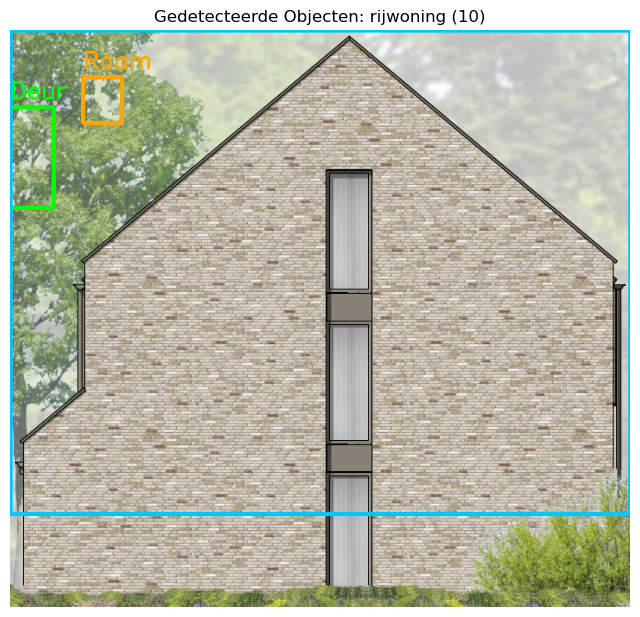

Opgeslagen: .\Old_school_AI_test_foto's\model_2\detectie_resultaat_rijwoning (10).jpg en .\Old_school_AI_test_foto's\model_2\detectie_rijwoning (10).json


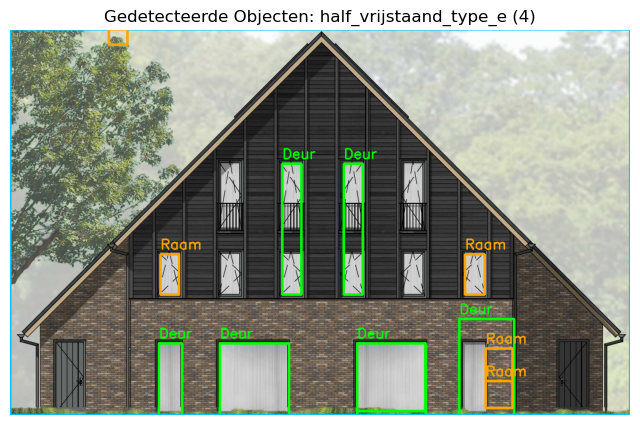

Opgeslagen: .\Old_school_AI_test_foto's\model_2\detectie_resultaat_half_vrijstaand_type_e (4).jpg en .\Old_school_AI_test_foto's\model_2\detectie_half_vrijstaand_type_e (4).json


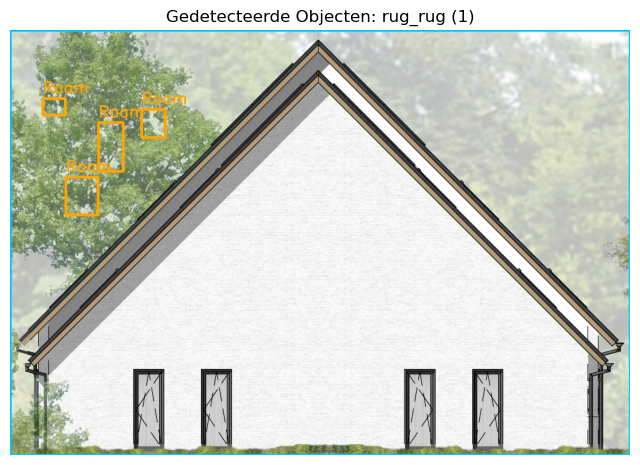

Opgeslagen: .\Old_school_AI_test_foto's\model_2\detectie_resultaat_rug_rug (1).jpg en .\Old_school_AI_test_foto's\model_2\detectie_rug_rug (1).json


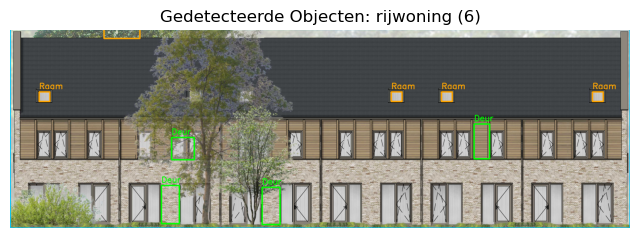

Opgeslagen: .\Old_school_AI_test_foto's\model_2\detectie_resultaat_rijwoning (6).jpg en .\Old_school_AI_test_foto's\model_2\detectie_rijwoning (6).json


In [ ]:
# Maak een relatief pad naar de opslagmap
save_folder = os.path.join(".", "Old_school_AI_test_foto's\model_3")
os.makedirs(save_folder, exist_ok=True)  # Zorg dat de map bestaat

# Lijst met relatieve paden naar je afbeeldingen
image_paths = [
    os.path.join("Data_nest_uitgesneden", "rijwoning (10).png"),
    os.path.join("Data_nest_uitgesneden", "half_vrijstaand_type_e (4).png"),
    os.path.join("Data_nest_uitgesneden", "rug_rug (1).png"),
    os.path.join("Data_nest_uitgesneden", "rijwoning (6).png")
]

# Parameters
min_area_deur = 5000
max_area_deur = 20000
min_area_raam = 1000
max_area_raam = 5000
kernel = np.ones((50, 50), np.uint8)

for path in image_paths:
    filename = os.path.splitext(os.path.basename(path))[0]
    img = cv2.imread(path)

    if img is None:
        print(f"Fout bij inladen afbeelding: {path}")
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (13, 13), 2.2)
    edges = cv2.Canny(blur, 50, 150)
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    output_img = img_rgb.copy()
    detected_objects = []

    if not contours:
        print(f"Geen contouren gevonden in afbeelding: {filename}")
        continue

    largest_cnt = max(contours, key=lambda c: cv2.boundingRect(c)[2] * cv2.boundingRect(c)[3])

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h

        if cnt is largest_cnt:
            label = "Huis"
            color = (0, 200, 255)
        elif min_area_deur < area < max_area_deur:
            label = "Deur"
            color = (0, 255, 0)
        elif min_area_raam < area < max_area_raam:
            label = "Raam"
            color = (255, 165, 0)
        else:
            continue

        cv2.rectangle(output_img, (x, y), (x + w, y + h), color, 3)
        cv2.putText(output_img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        detected_objects.append({
            "label": label,
            "bbox": [int(x), int(y), int(w), int(h)]
        })

    # Toon de afbeelding
    plt.figure(figsize=(8, 8))
    plt.imshow(output_img)
    plt.title(f"Gedetecteerde Objecten: {filename}")
    plt.axis('off')
    plt.show()

    # Opslaan
    result_image_path = os.path.join(save_folder, f"detectie_resultaat_{filename}.jpg")
    result_json_path = os.path.join(save_folder, f"detectie_{filename}.json")

    cv2.imwrite(result_image_path, cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))
    with open(result_json_path, "w") as f:
        json.dump(detected_objects, f, indent=2)

    print(f"Opgeslagen: {result_image_path} en {result_json_path}")

De laatste celcode is bedoeld voor het valideren van 4 geveltekeningen. Ze zijn opgeslagen in de juiste map om later te vergelijken met de juiste resultaat-/gelabelde geveltekening.